In [31]:
import numpy as np
from scipy import stats
import math
import os

In [32]:
# folder = "ChaCha-1000-000-Fixed-Nonce-STM"
folder = "ChaCha-1000-000-Fixed-Nonce-XMEGA"

In [ ]:
TRACE_CNT = None
TRACE_LEN = None
TRACE_FIXED_CNT = None
TRACE_RANDOM_CNT = None
CHUNK_SIZE = None
CHUNKS_CNT = None
def read_info(folder):
    """
    Read the info file to get the number of traces, chunk size, and trace length.
    """
    global CHUNK_SIZE, LAST_CHUNK_SIZE
    global CHUNKS_CNT
    with open(f"{folder}/info.txt", 'r') as file:
        global TRACE_CNT
        global TRACE_LEN
        global TRACE_RANDOM_CNT
        TRACE_CNT = int(file.readline())
        TRACE_RANDOM_CNT = TRACE_CNT
        TRACE_FIXED_CNT  = TRACE_CNT
        CHUNK_SIZE = int(file.readline())
        TRACE_LEN = int(file.readline())
        
    CHUNKS_CNT = math.ceil(TRACE_CNT / CHUNK_SIZE)
    LAST_CHUNK_SIZE = TRACE_CNT - (CHUNKS_CNT - 1)* CHUNK_SIZE
    print(f"TRACE_CNT = {TRACE_CNT}")   
    print(f"CHUNK_SIZE = {CHUNK_SIZE}")   
    print(f"LAST_CHUNK_SIZE = {LAST_CHUNK_SIZE}")   
    print(f"CHUNKS_CNT = {CHUNKS_CNT}")   
    print(f"TRACE_RANDOM_CNT = {TRACE_RANDOM_CNT}")   
    print(f"TRACE_LEN = {TRACE_LEN}")

In [34]:
read_info(folder)

TRACE_CNT = 500000
CHUNK_SIZE = 10000
LAST_CHUNK_SIZE = 10000
CHUNKS_CNT = 50
TRACE_RANDOM_CNT = 500000
TRACE_LEN = 4056


In [ ]:
TRACES_RANDOM = None
# Load traces from all chunks
# Initialize an empty list to store traces from each chunk
traces_list = []
for chunk_index in range(CHUNKS_CNT):
    chunk_folder = os.path.join(folder, f"chunk_{chunk_index}")
    chunk_file = os.path.join(chunk_folder, "traces_random.bin")

    if os.path.exists(chunk_file):
        with open(chunk_file, 'rb') as file:
            byte_array = file.read()

        if chunk_index != CHUNKS_CNT-1:
            chunk_traces = np.frombuffer(byte_array, dtype=np.uint16).reshape((CHUNK_SIZE, TRACE_LEN))
        else:
            chunk_traces = np.frombuffer(byte_array, dtype=np.uint16).reshape((LAST_CHUNK_SIZE, TRACE_LEN))

        traces_list.append(chunk_traces)
    else:
        print(f"Chunk file {chunk_file} does not exist.")

# Concatenate all chunks
TRACES_RANDOM = np.vstack(traces_list)


# Desired shape
desired_shape = (TRACE_CNT, TRACE_LEN)

# Check if the array has the desired shape
if TRACES_RANDOM.shape != desired_shape:
    # Trim the array to the desired shape
    TRACES_RANDOM = TRACES_RANDOM[:desired_shape[0], :desired_shape[1]]
    print(f"Trimming TRACES_RANDOM to {TRACES_RANDOM.shape}")

In [ ]:
TRACES_FIXED = None
# Load traces from all chunks
# Initialize an empty list to store traces from each chunk
traces_list = []
for chunk_index in range(CHUNKS_CNT):
    chunk_folder = os.path.join(folder, f"chunk_{chunk_index}")
    chunk_file = os.path.join(chunk_folder, "traces_fixed.bin")

    if os.path.exists(chunk_file):
        with open(chunk_file, 'rb') as file:
            byte_array = file.read()

        if chunk_index != CHUNKS_CNT-1:
            chunk_traces = np.frombuffer(byte_array, dtype=np.uint16).reshape((CHUNK_SIZE, TRACE_LEN))
        else:
            chunk_traces = np.frombuffer(byte_array, dtype=np.uint16).reshape((LAST_CHUNK_SIZE, TRACE_LEN))

        traces_list.append(chunk_traces)
    else:
        print(f"Chunk file {chunk_file} does not exist.")

# Concatenate all chunks
TRACES_FIXED = np.vstack(traces_list)


# Desired shape
desired_shape = (TRACE_CNT, TRACE_LEN)

# Check if the array has the desired shape
if TRACES_FIXED.shape != desired_shape:
    # Trim the array to the desired shape
    TRACES_FIXED = TRACES_FIXED[:desired_shape[0], :desired_shape[1]]
    print(f"Trimming TRACES_FIXED to {TRACES_FIXED.shape}")

<IPython.core.display.Javascript object>


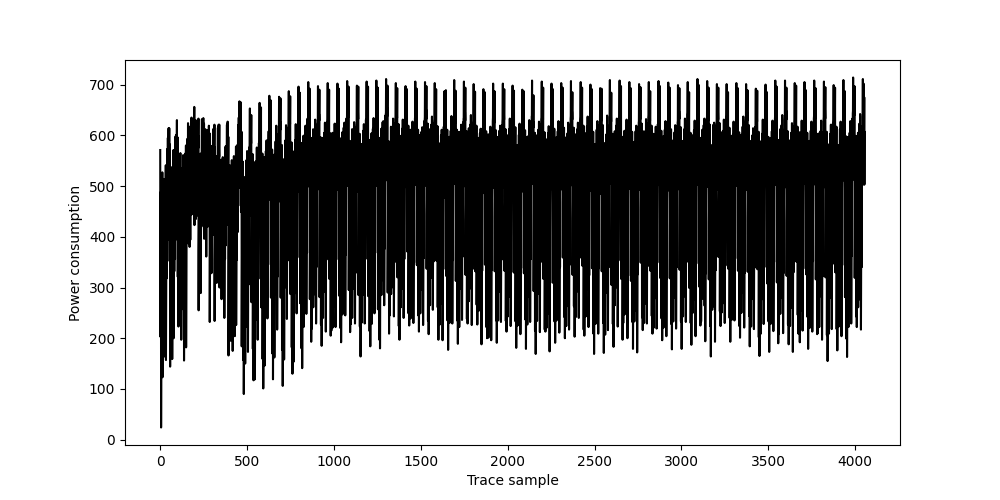

In [38]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure(figsize=(10, 5))
# plt.title(f'First trace from set using constant PT - CHACHA20')
plt.plot(TRACES_FIXED[0], "k")
plt.ylabel('Power consumption')
plt.xlabel('Trace sample')

plt.show()



In [ ]:
# import math
from scipy import stats

def calculate_t_statistics():
    """
    Calculate t-statistics and p-values for the traces.
    """
    global TRACE_LEN, TRACE_FIXED_CNT, TRACES_FIXED, TRACES_RANDOM
    threshold = 4.5
    p_value_threshold = 0.00001
    t_stats = []
    p_values = []
    accepted_threshold_count = 0
    p_val_accepted_threshold_count = 0
    
    for i in range(TRACE_LEN):
        samples_const = TRACES_FIXED[:, i]
        samples_random = TRACES_RANDOM[:, i]
        
        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
        res = stats.ttest_ind(samples_const, samples_random)
        
        if abs(res[0]) > threshold:
            accepted_threshold_count += 1
        
        if res[1] < p_value_threshold:
            p_val_accepted_threshold_count += 1
        
        t_stats.append(abs(res[0]))
        p_values.append(res[1])
    return t_stats, p_values, accepted_threshold_count, p_val_accepted_threshold_count

In [40]:
t_values, p_values, accepted_threshold_count, p_val_accepted_threshold_count = calculate_t_statistics()



<IPython.core.display.Javascript object>


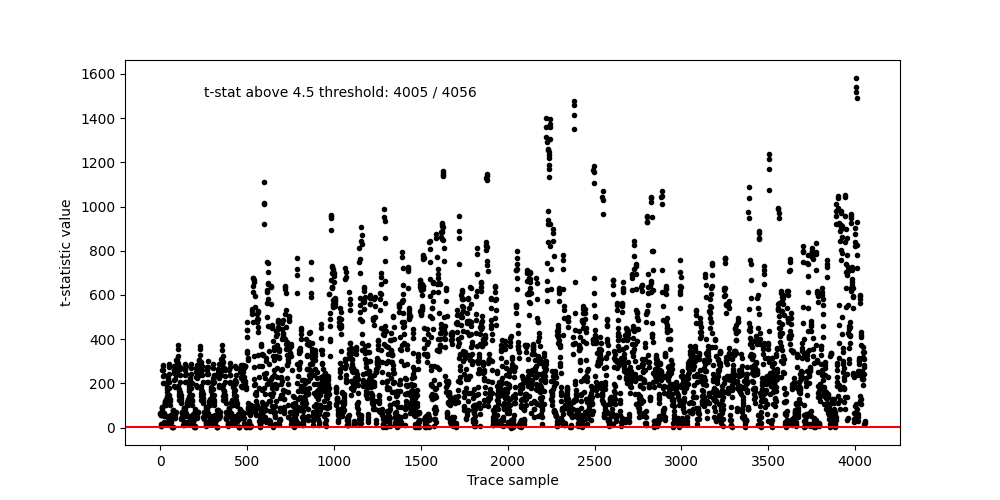

In [44]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure(figsize=(10, 5))
# plt.title(f't-statistic values for each sample point for CHACHA20')
plt.plot(t_values, 'k.')
plt.axhline(y = 4.5, color = 'r', label = 'axvline - full height')
plt.text(250,1500, f"t-stat above 4.5 threshold: {accepted_threshold_count} / {TRACE_LEN}")
plt.ylabel('t-statistic value')
plt.xlabel('Trace sample')
plt.show()

<IPython.core.display.Javascript object>


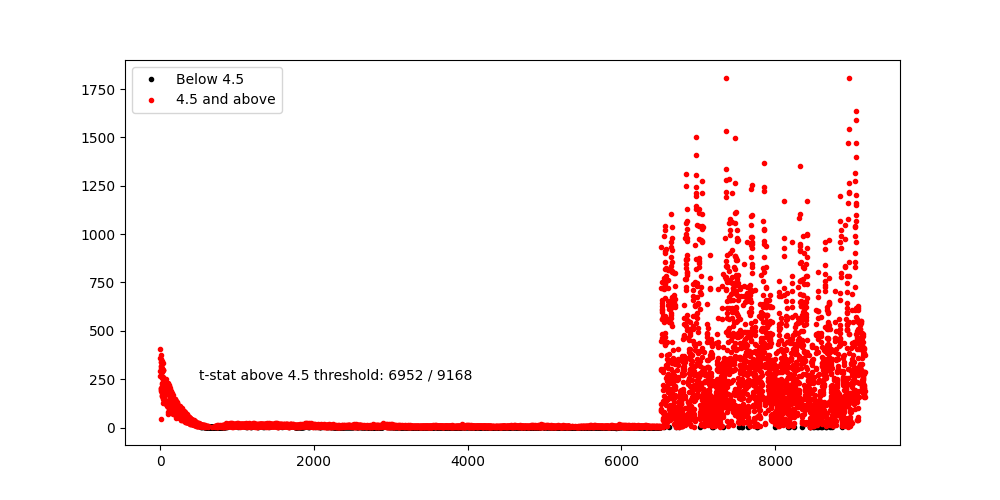

In [22]:
plt.figure(figsize=(10, 5))
# plt.title(f't-statistic values for each sample point for CHACHA20')

# Plot points with values below 4.5 in black
below_threshold = [val if val < 4.5 else None for val in t_values]
plt.plot(below_threshold, 'k.', label='Below 4.5')

# Plot points with values 4.5 and above in red
above_threshold = [val if val >= 4.5 else None for val in t_values]
plt.plot(above_threshold, 'r.', label='4.5 and above')

plt.text(500, 250, f"t-stat above 4.5 threshold: {accepted_threshold_count} / {TRACE_LEN}")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


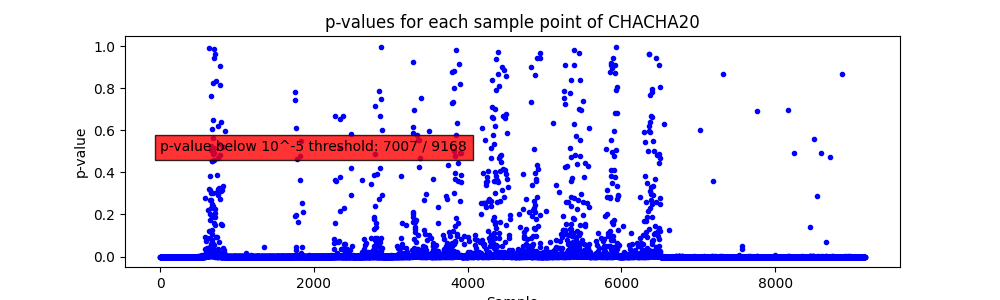

In [18]:
plt.figure(figsize=(10, 3))
plt.title(f'p-values for each sample point of CHACHA20')
plt.plot(p_values, 'b.')
plt.xlabel("Sample")
plt.ylabel("p-value")
plt.text(0,0.5, f"p-value below 10^-5 threshold: {p_val_accepted_threshold_count} / {TRACE_LEN}", bbox=dict(facecolor='red', alpha=0.8))
plt.show()